## Notebook setup

In [1]:
# Standard libraries
import os
import sys

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical libraries
import numpy as np
import pandas as pd
import patsy as pt
import pymc3 as pm
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.formula.api import ols
from theano import tensor as T

# Internal libraries
sys.path.append('../../src')
from lib.reconstruction.bayes.preprocessing.pivots import (load_tidy, 
                                                           compute_extra_tidy, 
                                                           compute_per_subject_pivot, 
                                                           compute_per_trial_pivot)
from lib.reconstruction.features import count_all_features

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Notebook configuration
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 100)
# os.environ['THEANO_FLAGS'] = 'device=cuda,floatX=float32'

sns.set_context('paper')
sns.set_style('white')

colors = sns.cubehelix_palette(n_colors=2, start=0.5, hue=1, rot=.1, light=.65) 
colors += sns.cubehelix_palette(n_colors=2, start=2.5, hue=1, rot=.1, light=.65)

%matplotlib inline

## Load data

In [3]:
tidy_df, board_set_df = load_tidy('../../etc/reconstruction/tidy_data.csv')

# One position was duplicated between real/fake positions; drop it from data
valid_ids = tidy_df.pivot_table(index='Position ID', values='Subject ID', aggfunc=len)
valid_ids = valid_ids.loc[valid_ids['Subject ID'] == 38]
valid_ids = valid_ids.index.tolist()
tidy_df = tidy_df.loc[tidy_df['Position ID'].isin(valid_ids)]
board_set_df = board_set_df.loc[valid_ids]
board_set_df.sort_index(inplace=True)
board_set_df.reset_index(inplace=True, drop=True)

upids = tidy_df.sort_values('Position ID')['Position ID'].unique()
pid_map = dict(zip(upids, np.arange(0, len(upids), 1, dtype=int)))
tidy_df['Position ID'] = tidy_df['Position ID'].map(pid_map)

extra_tidy_df = compute_extra_tidy(tidy_df)
per_trial_df = compute_per_trial_pivot(extra_tidy_df)
per_subject_df = compute_per_subject_pivot(per_trial_df)

In [4]:
# Add features
all_features = tidy_df.apply(count_all_features, axis=1)
feature_names = list(all_features.iloc[0].keys())
feature_base_names = list(set([fn[:-1] for fn in feature_names]))

for fn in feature_names:
    extra_tidy_df[f'feature_{fn}'] = np.concatenate(all_features.map(lambda x: x[fn]).values)
    
for bn in feature_base_names:
    b = np.concatenate(all_features.map(lambda x: x[f'{bn}b']).values)
    w = b = np.concatenate(all_features.map(lambda x: x[f'{bn}w']).values)
    extra_tidy_df[f'basef_{bn}'] = b + w
    
extra_tidy_df['same'] = extra_tidy_df['same'].astype(float)
extra_tidy_df['opposite'] = extra_tidy_df['opposite'].astype(float)

In [5]:
extra_tidy_df

,subject,condition_mask,occupied,color,same,opposite,position_type,position_id,errors_1,errors_2,errors_3,condition_indicator,usubject,has_error,error_type,feature_1100b,feature_1100w,feature_1010b,feature_1010w,feature_1001b,feature_1001w,feature_1110b,feature_1110w,feature_1101b,feature_1101w,feature_1111b,feature_1111w,basef_1010,basef_1100,basef_1110,basef_1111,basef_1001,basef_1101
0,0,Trained,1,1,0.0,0.333333,1,25,0,0,0,1,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,Trained,0,0,0.0,0.000000,1,25,0,0,0,1,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,Trained,0,0,0.0,0.000000,1,25,0,0,0,1,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,Trained,0,0,0.0,0.000000,1,25,0,0,0,1,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,Trained,0,0,0.0,0.000000,1,25,0,0,0,1,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128587,18,Untrained,1,1,0.0,0.400000,0,16,0,0,0,0,18,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128588,18,Untrained,0,0,0.0,0.000000,0,16,0,0,0,0,18,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128589,18,Untrained,1,1,0.0,0.200000,0,16,0,0,0,0,18,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
128590,18,Untrained,0,0,0.0,0.000000,0,16,0,0,0,0,18,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Data preprocessing

In [6]:
num_position_levels = len(extra_tidy_df.position_type.unique())
num_condition_levels = len(extra_tidy_df.condition_indicator.unique())
num_interaction_levels = num_position_levels * num_condition_levels
num_subjects = len(extra_tidy_df.usubject.unique())

In [7]:
extra_tidy_df['n_pieces'] = extra_tidy_df.position_id.map(board_set_df['Num Pieces'])

In [8]:
formula = 'errors_2 ~ C(usubject, Sum) + C(condition_indicator, Sum) * C(position_type, Sum)'
# formula = 'errors_2 ~ C(condition_indicator, Sum) * C(position_type, Sum)'
exogenous_df, endogenous_df = pt.dmatrices(formula, per_trial_df, 
                                           return_type='dataframe', 
                                           NA_action='raise')
endogenous_df = endogenous_df.astype(int)

In [9]:
extra_tidy_df['successes_2'] = extra_tidy_df['occupied'] - extra_tidy_df['errors_2']
# formula = 'errors_2 ~ C(usubject, Sum) + C(condition_indicator, Sum) * C(position_type, Sum)'
formula = 'errors_2 ~ C(condition_indicator, Sum) * C(position_type, Sum) + n_pieces + same + opposite'

# exogenous_df, endogenous_df = pt.dmatrices(formula, extra_tidy_df, 
#                                            return_type='dataframe', 
#                                            NA_action='raise')
# endogenous_df = endogenous_df.astype(int)

sm_model = sm.Logit.from_formula(formula, extra_tidy_df)
result = sm_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.286245
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               errors_2   No. Observations:               128592
Model:                          Logit   Df Residuals:                   128585
Method:                           MLE   Df Model:                            6
Date:                Thu, 28 Nov 2019   Pseudo R-squ.:                  0.1416
Time:                        20:28:13   Log-Likelihood:                -36809.
converged:                       True   LL-Null:                       -42882.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      -4.6367      0.067    -69.351      0.000      -4.768      -4.506
C(condition_indicator, Sum)[S.0]                                0.0738      0.010      7.480      0.000       0.054       0.093
C(position_type, Sum)[S.0]                                      0.3704      0.010     36.353      0.000       0.350       0.390
C(condition_indicator, Sum)[S.0]:C(position_type, Sum)[S.0]     0.0045      0.010      0.456      0.649      -0.015       0.024
n_pieces                                                        0.1076      0.004     24.385      0.000       0.099       0.116
same                                                            0.4505      0.063      7.163      0.000       0.327       0.574
opposite                                                        4.2410      0.050     84.942      0.000       4.143       4.339
===============================================================================================================================
"""

### Bayesian

In [36]:
extra_tidy_df['same'] = extra_tidy_df['same'].astype(float)
extra_tidy_df['opposite'] = extra_tidy_df['opposite'].astype(float)

# Important interactions:
# 1. color and feature
#    "Should a heuristic function distinguish between feature colors?"
# 2. training and feature
#    "Does prior experience with the game bias subjects towards features from the game model?"
# 3. same and opposite
#    "Do different colors in context have a simple impact?"
# 4. training and num_pieces (and position type?)
#    "Does game experience provide a subject with a more efficient position encoding scheme?"

formula = 'errors_2 ~ C(condition_indicator, Sum) * C(position_type, Sum) + '
formula += 'n_pieces + same + opposite + C(color, Sum) + '
formula += ' + '.join(f'basef_{bn}' for bn in feature_base_names)
formula += ' + C(usubject, Sum)'

# Interactions
# formula += ' + ' + ' + '.join(f'basef_{bn}:C(color, Sum)' for bn in feature_base_names)
formula += ' + ' + ' + '.join(f'basef_{bn}:C(condition_indicator, Sum)' for bn in feature_base_names)
formula += ' + ' + 'C(condition_indicator, Sum):n_pieces'

# old
# Feature names including color
# formula += ' + '.join(f'feature_{fn}' for fn in feature_names)


df = extra_tidy_df.copy()
df = df.loc[df['occupied'] == 1]
# df['n_pieces'] = df.n_pieces - df.n_pieces.max() + .5 * (df.n_pieces.max() - df.n_pieces.min())
# df['same'] = df.same - .5
# df['opposite'] = df.opposite - .5

exogenous_df, endogenous_df = pt.dmatrices(formula, df, 
                                           return_type='dataframe', 
                                           NA_action='raise')

index_cols = ['Intercept', 
              'C(condition_indicator, Sum)[S.0]', 
              'C(position_type, Sum)[S.0]', 
              'C(condition_indicator, Sum)[S.0]:C(position_type, Sum)[S.0]']

index_cols += [col for col in endogenous_df.columns if 'usubject' in col]

for c in index_cols:
    if c in endogenous_df.columns:
        endogenous_df[c] = endogenous_df[c].astype(int)
    
endogenous_df

,Intercept,"C(condition_indicator, Sum)[S.0]","C(position_type, Sum)[S.0]","C(color, Sum)[S.-1]","C(usubject, Sum)[S.0]","C(usubject, Sum)[S.1]","C(usubject, Sum)[S.2]","C(usubject, Sum)[S.3]","C(usubject, Sum)[S.4]","C(usubject, Sum)[S.5]","C(usubject, Sum)[S.6]","C(usubject, Sum)[S.7]","C(usubject, Sum)[S.8]","C(usubject, Sum)[S.9]","C(usubject, Sum)[S.10]","C(usubject, Sum)[S.11]","C(usubject, Sum)[S.12]","C(usubject, Sum)[S.13]","C(usubject, Sum)[S.14]","C(usubject, Sum)[S.15]",...,"C(usubject, Sum)[S.34]","C(usubject, Sum)[S.35]","C(usubject, Sum)[S.36]","C(condition_indicator, Sum)[S.0]:C(position_type, Sum)[S.0]",n_pieces,"C(condition_indicator, Sum)[S.0]:n_pieces",same,opposite,basef_1010,"basef_1010:C(condition_indicator, Sum)[S.0]",basef_1100,"basef_1100:C(condition_indicator, Sum)[S.0]",basef_1110,"basef_1110:C(condition_indicator, Sum)[S.0]",basef_1111,"basef_1111:C(condition_indicator, Sum)[S.0]",basef_1001,"basef_1001:C(condition_indicator, Sum)[S.0]",basef_1101,"basef_1101:C(condition_indicator, Sum)[S.0]"
0,1,-1,-1,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,15.0,-15.0,0.000,0.333333,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
10,1,-1,-1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,15.0,-15.0,0.125,0.250000,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
11,1,-1,-1,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,15.0,-15.0,0.125,0.375000,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
12,1,-1,-1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,15.0,-15.0,0.125,0.500000,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
13,1,-1,-1,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,15.0,-15.0,0.500,0.125000,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128584,1,1,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,14.0,14.0,0.200,0.200000,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128585,1,1,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,14.0,14.0,0.400,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128586,1,1,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,14.0,14.0,0.200,0.200000,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128587,1,1,1,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,14.0,14.0,0.000,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
coeff_spec = {'condition': ['C(condition_indicator, Sum)[S.0]'],
              'position': ['C(position_type, Sum)[S.0]'],
              'interaction': ['C(condition_indicator, Sum)[S.0]:C(position_type, Sum)[S.0]'],
              'n_pieces': ['n_pieces'],
              'same': ['same'],
              'opposite': ['opposite'],
              'color': ['C(color, Sum)[S.-1]'],
              'features': [c for c in endogenous_df.columns 
                           if 'basef' in c and 'color' not in c and 'condition_indicator' not in c],
#               'features_x_color': [c for c in endogenous_df.columns 
#                                    if 'basef' in c and 'color' in c],
              'features_x_condition': [c for c in endogenous_df.columns 
                                       if 'basef' in c and 'condition_indicator' in c],
              'condition_x_n_pieces': ['C(condition_indicator, Sum)[S.0]:n_pieces'],
#               'same_x_opposite': ['same:opposite'],
#               'subjects': [c for c in endogenous_df.columns if 'usubject' in c]
             }


def create_coeff(name, shape, mu=0):
#     sigma = pm.Gamma(f'sigma_{name}', 1.64, .32)
    a = pm.Normal(f'a_{name}', mu=0, sigma=1, shape=shape)
    return a


with pm.Model() as logistic_anova:
    # Create intercept coefficient; no prior on variance
    b0 = pm.Normal('intercept', mu=0, sd=1, shape=[1])
    coeffs = {k: create_coeff(k, [len(v)]) 
              for k, v in coeff_spec.items()}
    
#     B = T.concatenate([b for _, b in coeffs.items()])
#     mu = b0 + T.sum(B * endogenous_df.values[:, 1:], axis=1)
    mu = [coeffs[k] * endogenous_df[v].values 
          for k, v in coeff_spec.items()]
        
    mu = b0 + T.sum(T.concatenate(mu, axis=1), axis=1)
        
    mu = pm.invlogit(mu)
#     kappa = pm.Gamma('beta_variance', .01, .01)
#     alpha = mu * (kappa - 2) + 1
#     beta = (1 - mu) * (kappa - 2) + 1

#     theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=exogenous_df.shape[0])
    y = pm.Bernoulli('targets', p=mu, observed=exogenous_df['errors_2'].values)

In [102]:
with logistic_anova:
    step = pm.NUTS(target_accept=.98, max_treedepth=10)
    trace = pm.sample(2500, step, tune=2500, chains=6, cores=6) #, start=start)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [a_condition_x_n_pieces, a_features_x_condition, a_features, a_color, a_opposite, a_same, a_n_pieces, a_interaction, a_position, a_condition, intercept]
Sampling 6 chains:  58%|█████▊    | 17400/30000 [3:45:03<2:06:16,  1.66draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 6 chains:  99%|█████████▉| 29798/30000 [5:58:18<02:22,  1.42draws/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.

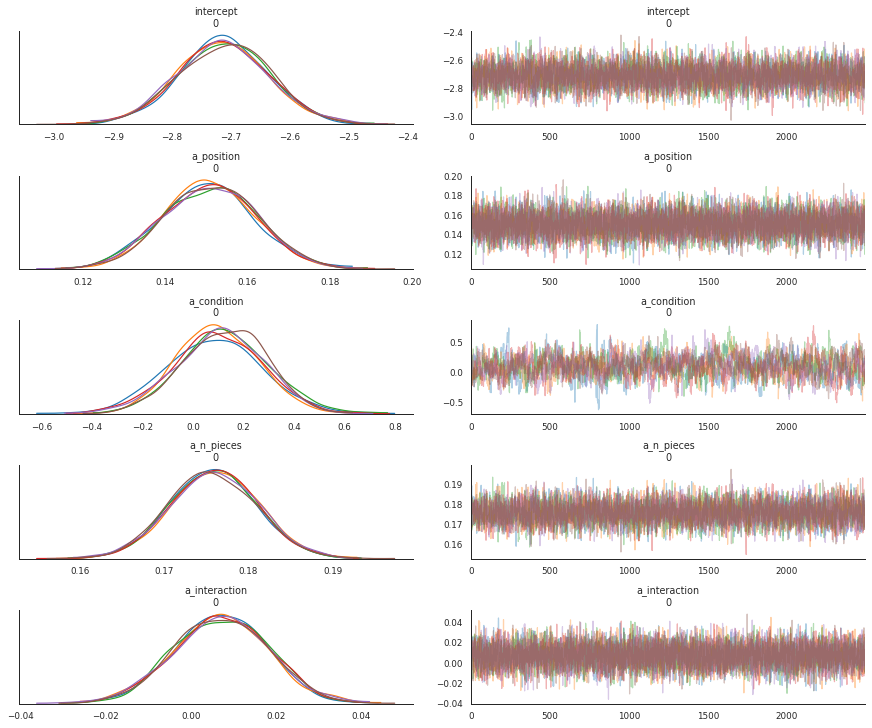

In [39]:
sns.set_style('white')
pm.traceplot(trace, var_names=['intercept', 'a_position', 'a_condition', 'a_n_pieces', 'a_interaction'])
sns.despine();

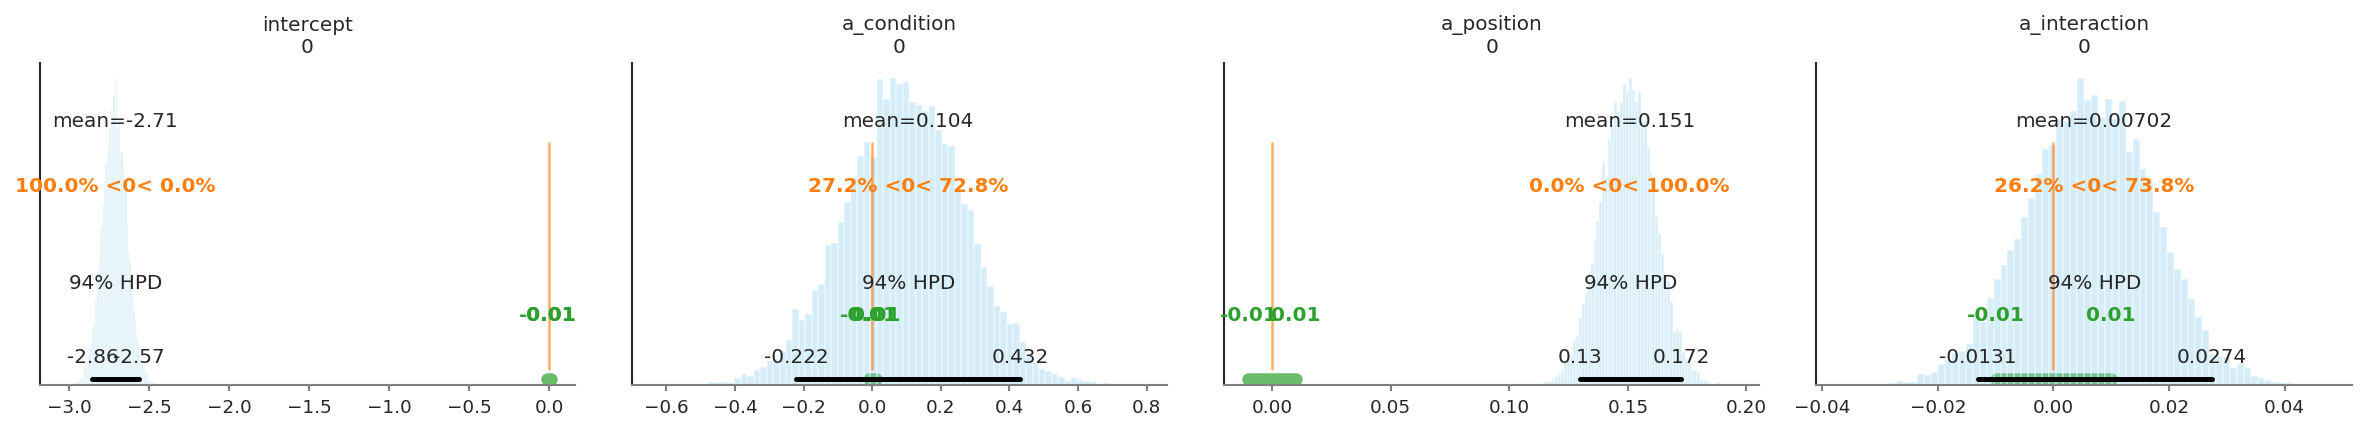

In [40]:
sns.set_style('white')

fig, axes = plt.subplots(1, 4, figsize=(16, 3), dpi=150)

var_names = ['intercept', 'a_condition', 'a_position', 'a_interaction']

pm.plot_posterior(trace, 
                  var_names=var_names,
                  color='#87ceeb', kind='hist', ax=axes,
                  rope=(-.01, .01), ref_val=0, round_to=3)

sns.despine()
plt.tight_layout();

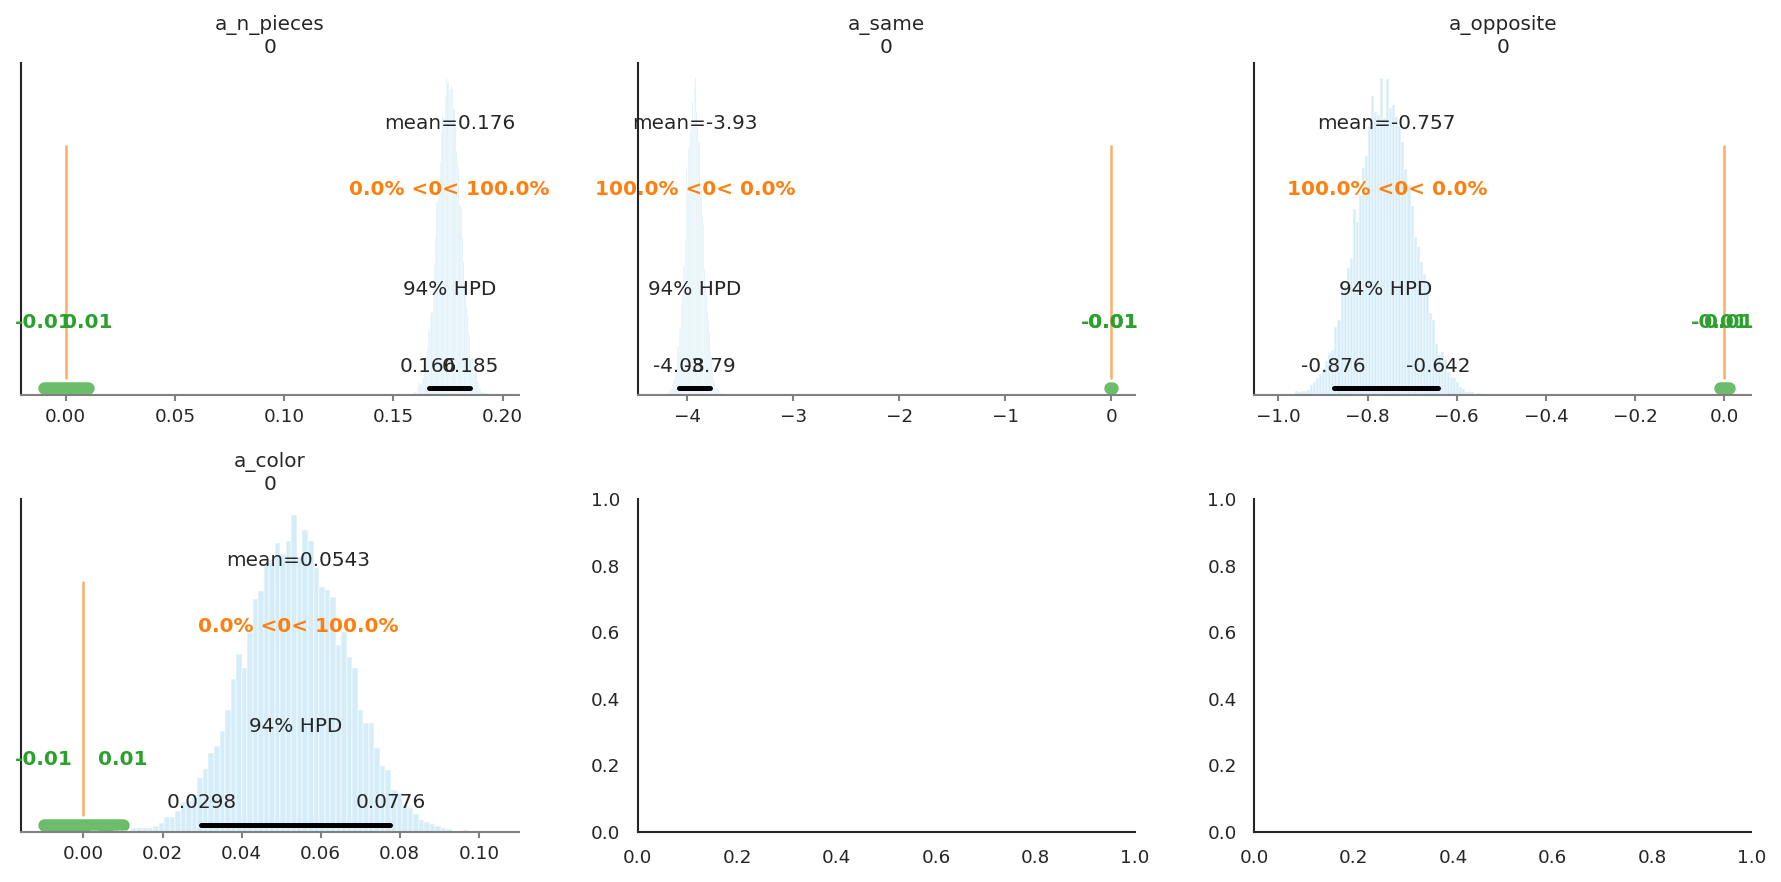

In [41]:
sns.set_style('white')

fig, axes = plt.subplots(2, 3, figsize=(12, 6), dpi=150)

var_names = ['a_n_pieces', 'a_same', 'a_opposite', 'a_color',] # 'a_condition_x_n_pieces', 'a_same_x_opposite']

pm.plot_posterior(trace, 
                  var_names=var_names,
                  color='#87ceeb', kind='hist', ax=axes,
                  rope=(-.01, .01), ref_val=0, round_to=3)

sns.despine()
plt.tight_layout();

['1010', '1100', '1110', '1111', '1001', '1101']


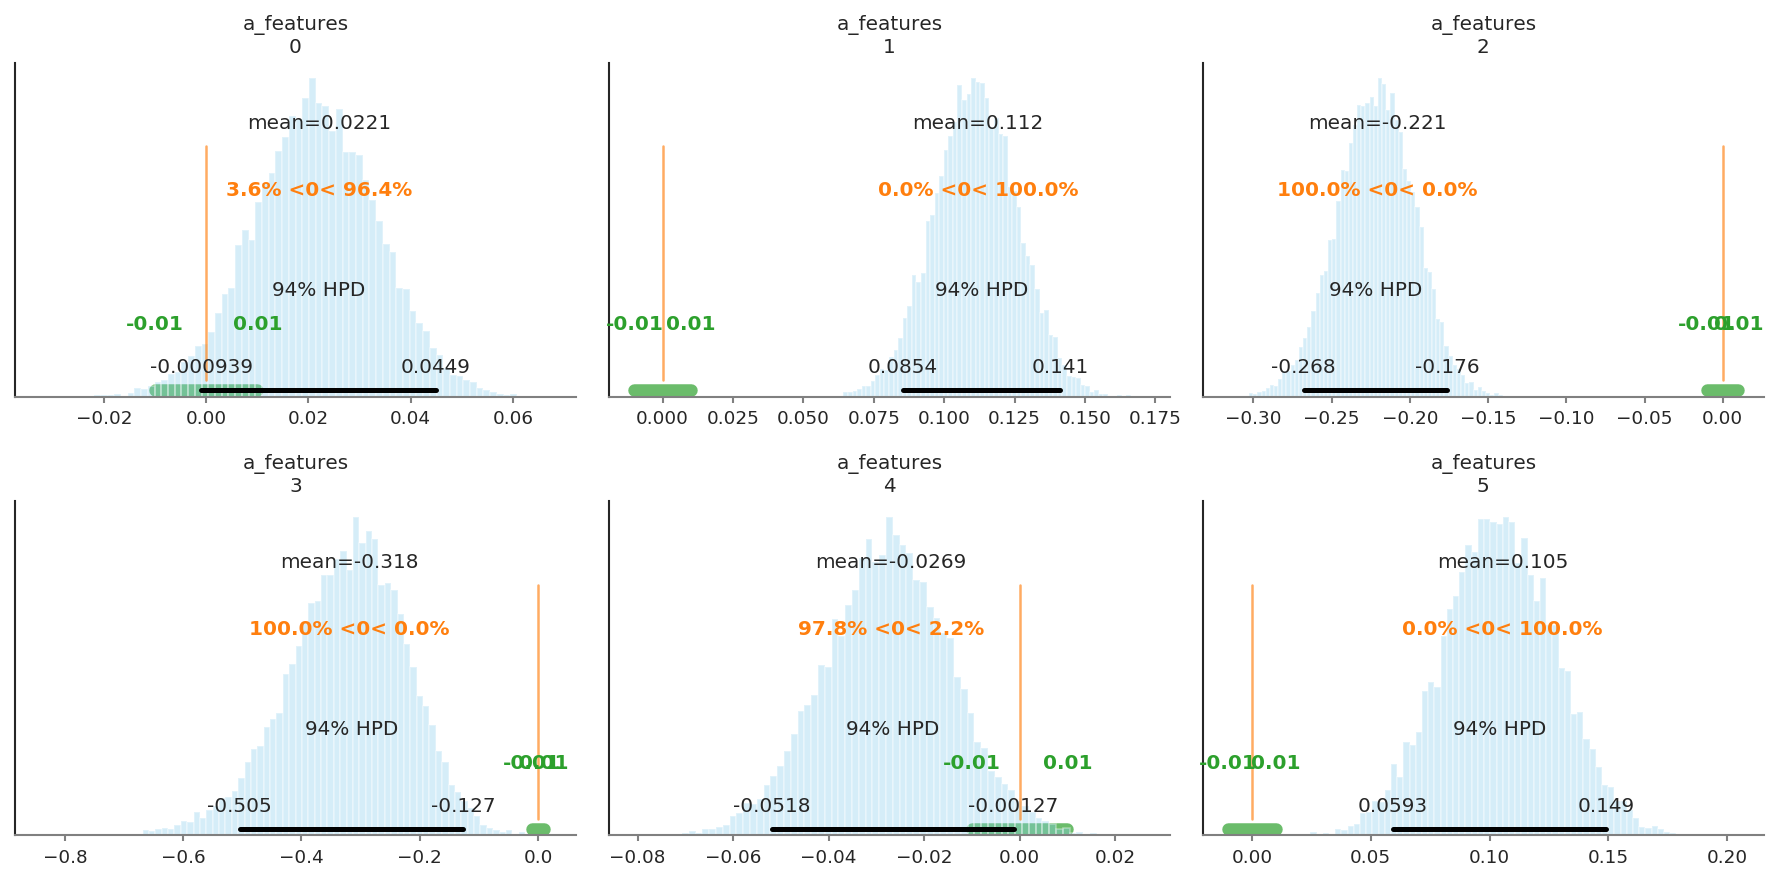

In [42]:
sns.set_style('white')

fig, axes = plt.subplots(2, 3, figsize=(12, 6), dpi=150)

var_names = ['a_features',] # 'a_features_x_color', 'a_features_x_condition']

pm.plot_posterior(trace, 
                  var_names=var_names,
                  color='#87ceeb', kind='hist', ax=axes,
                  rope=(-.01, .01), ref_val=0, round_to=3)

print(feature_base_names)
sns.despine()
plt.tight_layout();

['1010', '1100', '1110', '1111', '1001', '1101']


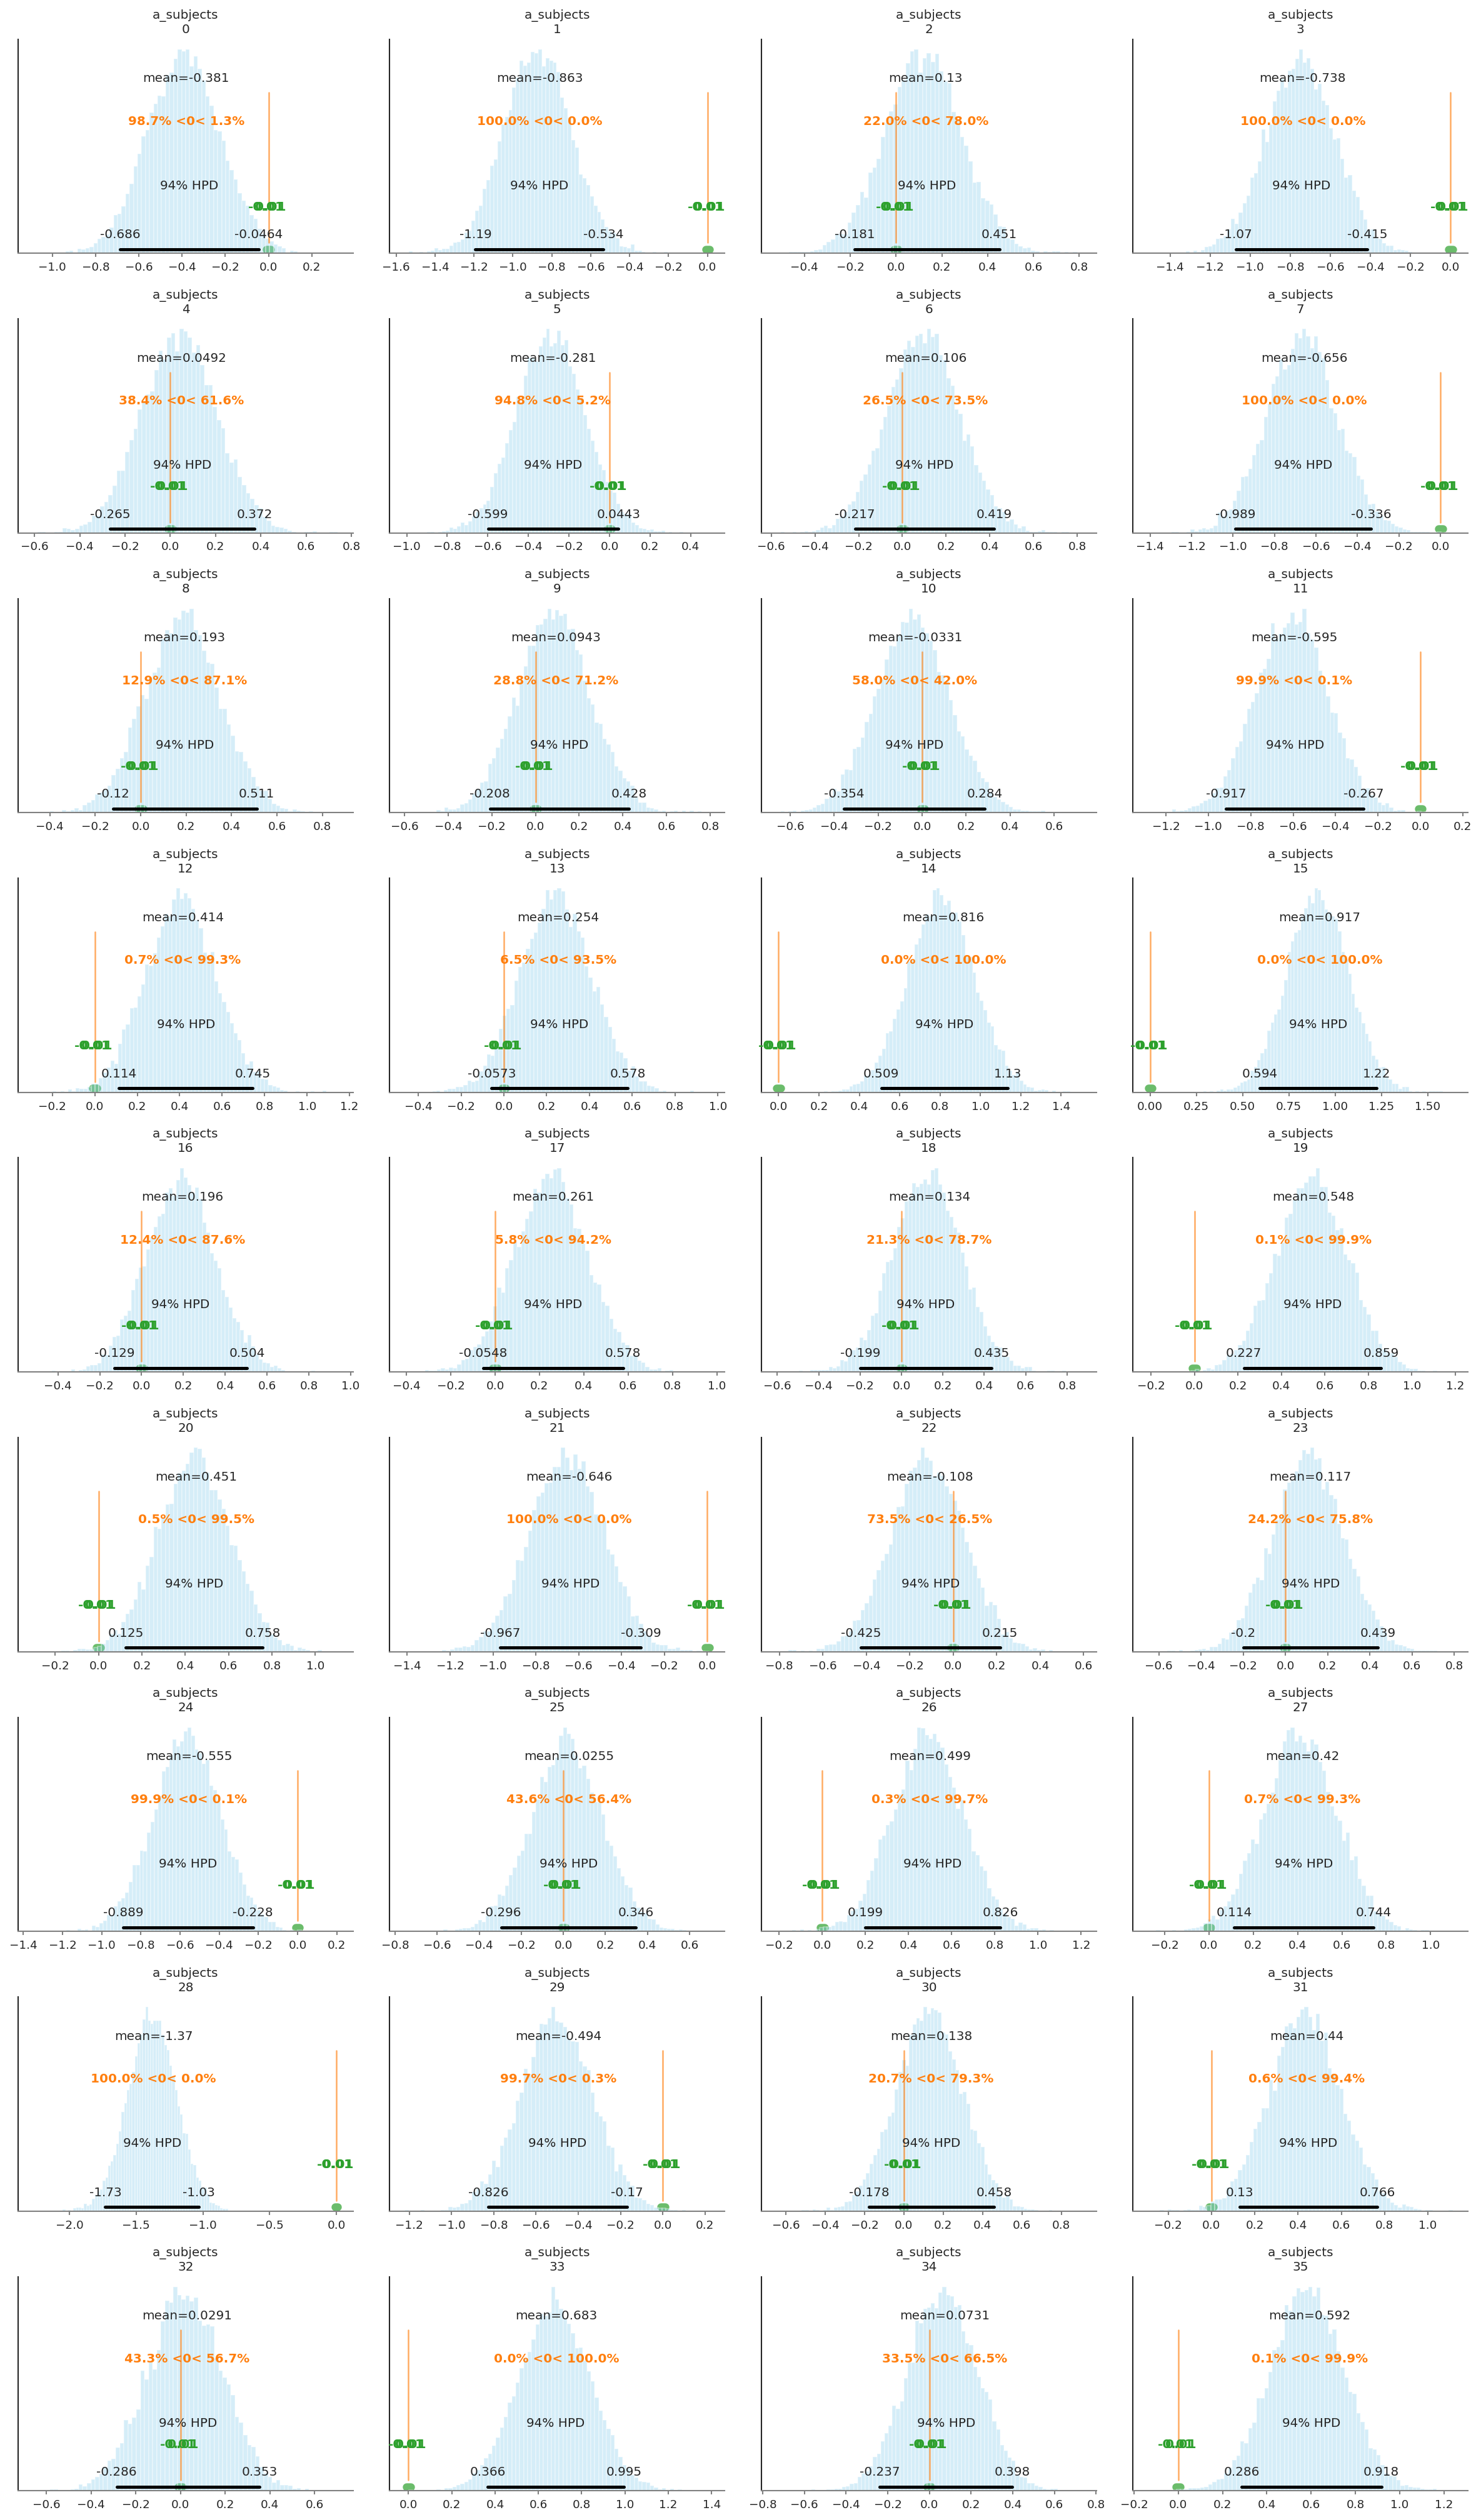

In [43]:
sns.set_style('white')

fig, axes = plt.subplots(9, 4, figsize=(16, 27), dpi=150)

var_names = ['a_subjects',] # 'a_features_x_color', 'a_features_x_condition']

pm.plot_posterior(trace, 
                  var_names=var_names,
                  color='#87ceeb', kind='hist', ax=axes,
                  rope=(-.01, .01), ref_val=0, round_to=3)

print(feature_base_names)
sns.despine()
plt.tight_layout();

In [67]:
endogenous_df.tail(2)

,Intercept,"C(condition_indicator, Sum)[S.0]","C(position_type, Sum)[S.0]","C(color, Sum)[S.-1]","C(usubject, Sum)[S.0]","C(usubject, Sum)[S.1]","C(usubject, Sum)[S.2]","C(usubject, Sum)[S.3]","C(usubject, Sum)[S.4]","C(usubject, Sum)[S.5]","C(usubject, Sum)[S.6]","C(usubject, Sum)[S.7]","C(usubject, Sum)[S.8]","C(usubject, Sum)[S.9]","C(usubject, Sum)[S.10]","C(usubject, Sum)[S.11]","C(usubject, Sum)[S.12]","C(usubject, Sum)[S.13]","C(usubject, Sum)[S.14]","C(usubject, Sum)[S.15]",...,"C(usubject, Sum)[S.34]","C(usubject, Sum)[S.35]","C(usubject, Sum)[S.36]","C(condition_indicator, Sum)[S.0]:C(position_type, Sum)[S.0]",n_pieces,"C(condition_indicator, Sum)[S.0]:n_pieces",same,opposite,basef_1010,"basef_1010:C(condition_indicator, Sum)[S.0]",basef_1100,"basef_1100:C(condition_indicator, Sum)[S.0]",basef_1110,"basef_1110:C(condition_indicator, Sum)[S.0]",basef_1111,"basef_1111:C(condition_indicator, Sum)[S.0]",basef_1001,"basef_1001:C(condition_indicator, Sum)[S.0]",basef_1101,"basef_1101:C(condition_indicator, Sum)[S.0]"
128587,1,1,1,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,14.0,14.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128589,1,1,1,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,14.0,14.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
c = np.squeeze(trace.get_values('a_condition'))
s = trace.get_values('a_subjects')

In [85]:
# s = s - s.mean(axis=1, keepdims=True)
s_tr = s[:, :19]
s_na = np.concatenate((s[:, 19:], -s.sum(axis=1, keepdims=True)), axis=1)

In [86]:
m_tr = s_tr.mean(axis=1)
m_na = s_na.mean(axis=1)

In [87]:
# first, mean correct all subjects

In [97]:
np.log(np.exp(c) / np.exp(m_tr) * np.exp(m_na))

0.10237161294226901

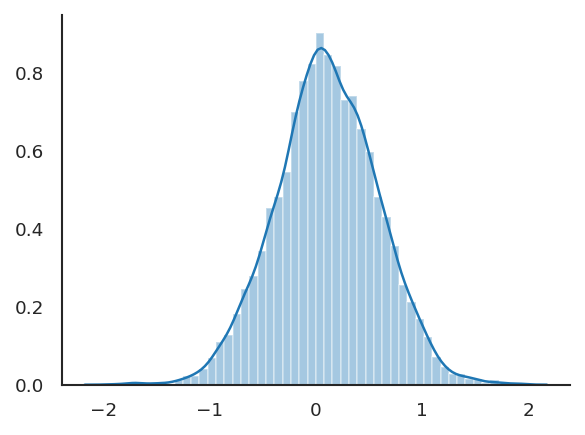

In [100]:
# Check condition adjusted by subject

sns.set_style('white')

fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sns.distplot(np.log(np.exp(c) / np.exp(m_tr) * np.exp(m_na)), ax=axes)

sns.despine()
fig.tight_layout();